# Setup
## Imports

In [1]:
%load_ext autoreload
%autoreload 2


In [63]:
import matplotlib.pyplot as plt
import json
import pandas as pd

from generative_social_choice.utils.helper_functions import get_base_dir_path
from generative_social_choice.slates.voting_utils import gini
from generative_social_choice.ratings.utility_matrix import extract_voter_utilities_from_info_csv
from generative_social_choice.utils.postprocessing import (
    plot_sorted_utility_distributions,
    plot_likert_category_clustered_bar_chart,
    scalar_utility_metrics,
    plot_candidate_distribution_stacked,
    plot_sorted_utility_CIs,
    consolidate_duplicate_columns,
)
from generative_social_choice.slates.voting_algorithms import (
    GreedyTotalUtilityMaximization,
    ExactTotalUtilityMaximization,
    LPTotalUtilityMaximization,
    ReweightedRangeVoting,
    GeometricTransformation,
)


## Load data

In [3]:
from generative_social_choice.utils.helper_functions import get_results_paths

LABELLING_MODEL = "4o-mini"

our_pipeline_result_dirs = [get_results_paths(labelling_model=LABELLING_MODEL, baseline=False, run_id=s,  embedding_type="llm")['utility_matrix_file'] for s in range(10)]
our_pipeline_result_dirs

[WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/0/generated_with_4o_using_llm_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/1/generated_with_4o_using_llm_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/2/generated_with_4o_using_llm_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/3/generated_with_4o_using_llm_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/4/generated_with_4o_

In [4]:
baseline_result_dirs = [get_results_paths(labelling_model=LABELLING_MODEL, baseline=False, run_id=f"fish_{s}",  embedding_type="fish")['utility_matrix_file'] for s in range(10)]
baseline_result_dirs

[WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/fish_0/generated_with_4o_using_fish_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/fish_1/generated_with_4o_using_fish_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/fish_2/generated_with_4o_using_fish_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/fish_3/generated_with_4o_using_fish_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/stateme

In [5]:
# Load csvs
from pathlib import Path

# Load and merge our pipeline results
dfs_ours = []
for run_id, csv_path in enumerate(our_pipeline_result_dirs):
    df = pd.read_csv(csv_path, index_col=0, header=[0])
    # Create multiindex columns: (run_id, statement_id)
    df.columns = pd.MultiIndex.from_product([[run_id], df.columns], names=['run_id', 'statement_id'])
    dfs_ours.append(df)

# Merge all our pipeline dataframes
df_ours = pd.concat(dfs_ours, axis=1)
df_ours

run_id           0                                                         \
statement_id    s1   s2   s3   s4   s5   s6        s7        s8        s9   
generation1    1.0  2.0  3.0  2.0  3.0  2.0  3.942932  2.840580  3.633299   
generation2    0.0  1.0  3.0  0.0  2.0  0.0  3.778286  2.946926  3.324725   
generation3    4.0  4.0  4.0  0.0  4.0  4.0  3.986486  3.936705  3.935221   
generation4    2.0  1.0  4.0  3.0  2.0  1.0  3.998020  2.813964  3.991555   
generation5    2.0  1.0  4.0  4.0  4.0  2.0  3.989969  3.790196  3.992708   
...            ...  ...  ...  ...  ...  ...       ...       ...       ...   
generation96   4.0  4.0  4.0  1.0  4.0  4.0  3.985740  3.873320  3.996167   
generation97   1.0  2.0  3.0  1.0  3.0  2.0  3.271004  2.944387  3.177310   
generation98   2.0  2.0  4.0  1.0  4.0  2.0  3.967588  3.133832  3.960430   
generation99   3.0  2.0  2.0  2.0  2.0  2.0  3.093474  1.908323  3.386969   
generation100  4.0  2.0  3.0  0.0  4.0  2.0  3.832684  2.951767  3.894737   

run_id                   ...         9                                \
statement_id        s10  ...       s39       s40       s41       s42   
generation1    2.949145  ...  3.609351  3.197353  3.170728  3.828508   
generation2    3.002814  ...  3.670735  3.090738  3.245388  3.499778   
generation3    3.924433  ...  3.993985  3.943741  3.977463  3.996139   
generation4    2.214226  ...  3.989284  3.251406  3.805581  3.984649   
generation5    3.916218  ...  3.967461  3.840784  3.966082  3.984714   
...                 ...  ...       ...       ...       ...       ...   
generation96   3.907693  ...  3.990511  3.951611  3.985165  3.983180   
generation97   2.925313  ...  3.224383  3.002321  3.014461  3.605246   
generation98   3.637952  ...  3.967969  3.736390  3.841854  3.965997   
generation99   2.120680  ...  3.254601  2.689543  2.778984  3.111632   
generation100  3.942743  ...  3.391559  3.768503  3.800592  3.886451   

run_id                                                                     
statement_id        s43       s44       s45       s46       s47       s48  
generation1    2.909827  3.054797  3.657096  3.006715  3.604248  3.215762  
generation2    2.839152  3.001164  3.099498  2.958108  3.432330  3.264613  
generation3    3.916983  3.940950  3.994327  3.944833  3.962288  3.995228  
generation4    3.444030  3.439042  3.971363  2.002482  3.993974  3.988233  
generation5    3.925103  3.938816  3.981071  3.916113  3.989769  3.965867  
...                 ...       ...       ...       ...       ...       ...  
generation96   3.921185  3.893748  3.974451  3.941803  3.974463  3.980517  
generation97   2.938522  2.946576  3.038197  2.968257  3.157370  3.091172  
generation98   3.683667  2.590904  3.984286  3.311317  3.932757  3.987983  
generation99   2.200140  2.081919  2.499701  2.234431  2.713442  3.014619  
generation100  3.355423  3.600714  3.151169  3.487188  3.815436  3.682956  

[100 rows x 480 columns]

In [6]:

# Load and merge baseline results
dfs_baseline = []
for run_id, csv_path in enumerate(baseline_result_dirs):
    df = pd.read_csv(csv_path, index_col=0, header=[0])
    # Create multiindex columns: (run_id, statement_id)
    df.columns = pd.MultiIndex.from_product([[run_id], df.columns], names=['run_id', 'statement_id'])
    dfs_baseline.append(df)

# Merge all baseline dataframes
df_baseline = pd.concat(dfs_baseline, axis=1)

print(f"df_ours shape: {df_ours.shape}")
print(f"df_baseline shape: {df_baseline.shape}")

df_baseline

df_ours shape: (100, 480)
df_baseline shape: (100, 480)


run_id           0                                                         \
statement_id    s1   s2   s3   s4   s5   s6        s7        s8        s9   
generation1    1.0  2.0  3.0  2.0  3.0  2.0  3.606878  2.374456  3.340033   
generation2    0.0  1.0  3.0  0.0  2.0  0.0  3.133320  2.266603  3.291070   
generation3    4.0  4.0  4.0  0.0  4.0  4.0  3.993128  3.886643  3.947126   
generation4    2.0  1.0  4.0  3.0  2.0  1.0  3.997281  1.884515  3.976752   
generation5    2.0  1.0  4.0  4.0  4.0  2.0  3.974187  2.907868  3.985886   
...            ...  ...  ...  ...  ...  ...       ...       ...       ...   
generation96   4.0  4.0  4.0  1.0  4.0  4.0  3.971385  3.815710  3.986407   
generation97   1.0  2.0  3.0  1.0  3.0  2.0  3.012188  1.990670  3.020738   
generation98   2.0  2.0  4.0  1.0  4.0  2.0  3.983599  1.968843  3.960472   
generation99   3.0  2.0  2.0  2.0  2.0  2.0  2.420106  2.017674  2.431835   
generation100  4.0  2.0  3.0  0.0  4.0  2.0  3.311947  3.565987  3.899519   

run_id                   ...         9                                \
statement_id        s10  ...       s39       s40       s41       s42   
generation1    3.496645  ...  2.474659  3.841186  2.877509  2.923776   
generation2    3.541779  ...  2.755765  3.018781  3.004990  2.969787   
generation3    3.986632  ...  3.906482  3.990423  3.917975  3.973903   
generation4    3.918682  ...  2.022967  3.974662  3.076907  2.227909   
generation5    3.990719  ...  3.632825  3.982241  3.968195  3.429931   
...                 ...  ...       ...       ...       ...       ...   
generation96   3.973245  ...  3.949032  3.968847  3.936251  3.932352   
generation97   3.002595  ...  2.110535  2.942924  2.984580  2.467057   
generation98   3.943336  ...  2.027830  3.872548  2.295713  2.290003   
generation99   2.904756  ...  2.015156  2.253268  1.737717  2.030022   
generation100  3.922447  ...  3.484571  3.188023  2.888499  3.537063   

run_id                                                                     
statement_id        s43       s44       s45       s46       s47       s48  
generation1    2.874346  3.305598  1.999577  3.759770  2.968578  3.464279  
generation2    2.913503  3.213426  2.123531  3.758277  2.976942  3.199522  
generation3    3.939382  3.987964  3.879820  3.990560  3.974247  3.984298  
generation4    2.586662  3.934105  1.326481  3.994621  2.229146  3.916668  
generation5    3.179526  3.991991  3.029434  3.975952  3.851411  3.942721  
...                 ...       ...       ...       ...       ...       ...  
generation96   3.895415  3.977688  3.768560  3.985629  3.947697  3.952429  
generation97   2.712076  3.107788  2.000237  3.253274  2.712322  3.045255  
generation98   2.274354  3.987511  1.961220  3.941880  2.000546  3.985485  
generation99   2.125922  2.555855  1.985011  3.310624  2.299399  2.840858  
generation100  3.446954  3.381512  3.014448  3.829959  3.252540  3.799049  

[100 rows x 480 columns]

# Run Voting Algorithms

In [7]:
voting_algorithms_to_test = (
    GreedyTotalUtilityMaximization(),
    ExactTotalUtilityMaximization(),
    LPTotalUtilityMaximization(),
    # GreedyTotalUtilityMaximization(utility_transform=GeometricTransformation(p=1.5)),
    ExactTotalUtilityMaximization(utility_transform=GeometricTransformation(p=1.5)),
    # LPTotalUtilityMaximization(utility_transform=GeometricTransformation(p=1.5)),
    # GreedyTotalUtilityMaximization(utility_transform=GeometricTransformation(p=10.0)),
    # ExactTotalUtilityMaximization(utility_transform=GeometricTransformation(p=10.0)),
    # LPTotalUtilityMaximization(utility_transform=GeometricTransformation(p=10.0)),
    # *all_instances(SequentialPhragmenMinimax),
    # SequentialPhragmenMinimax(load_magnitude_method="marginal_slate", clear_reassigned_loads=True, redistribute_defected_candidate_loads=False),
    # SequentialPhragmenMinimax(load_magnitude_method="marginal_slate", clear_reassigned_loads=False, redistribute_defected_candidate_loads=False),
    # SequentialPhragmenMinimax(load_magnitude_method="marginal_previous", clear_reassigned_loads=True, redistribute_defected_candidate_loads=True),
    # SequentialPhragmenMinimax(),
    ReweightedRangeVoting(),
    ReweightedRangeVoting(k=0.5),
)

## Our Pipeline

In [28]:
from generative_social_choice.slates.voting_utils import voter_utilities

# Set slate size (number of statements to select)
SLATE_SIZE = 5

# Store results for each run and algorithm
results_data = []

# Iterate through each run in df_ours
for run_id in df_ours.columns.get_level_values('run_id').unique():
    # Extract utility matrix for this run
    utility_matrix = df_ours[run_id]
    
    # Run each voting algorithm
    for voting_algorithm in voting_algorithms_to_test:
        # Run the voting algorithm
        slate, assignments = voting_algorithm.vote(
            rated_votes=utility_matrix.copy(),
            slate_size=SLATE_SIZE
        )
        
        # Extract voter utilities from assignments
        # assignments is a DataFrame with 'candidate_id' column
        voter_utilities_series = voter_utilities(
            rated_votes=utility_matrix,
            assignments_series=assignments['candidate_id'],
            output_column_name='utility'
        )
        
        # Store the result with run_id and algorithm name
        results_data.append({
            'run_id': run_id,
            'algorithm': voting_algorithm,
            'utilities': voter_utilities_series,
            'assignments': assignments['candidate_id'],
            'slate': sorted(slate)
        })

# Create dataframe with multiindex columns for voter utilities
dfs_utilities_list = []
for result in results_data:
    df_temp = pd.DataFrame({
        (result['run_id'], result['algorithm']): result['utilities']
    })
    df_temp.columns = pd.MultiIndex.from_tuples(
        df_temp.columns, 
        names=['run_id', 'algorithm']
    )
    dfs_utilities_list.append(df_temp)

# Concatenate all dataframes
df_voter_utilities = pd.concat(dfs_utilities_list, axis=1)

# Create dataframe with multiindex columns for voter assignments
dfs_assignments_list = []
for result in results_data:
    df_temp = pd.DataFrame({
        (result['run_id'], result['algorithm']): result['assignments']
    })
    df_temp.columns = pd.MultiIndex.from_tuples(
        df_temp.columns, 
        names=['run_id', 'algorithm']
    )
    dfs_assignments_list.append(df_temp)

# Concatenate all dataframes
df_voter_assignments = pd.concat(dfs_assignments_list, axis=1)

# Create dataframe for slates
# Index is range(SLATE_SIZE), columns are (run_id, algorithm)
slate_data = {}
for result in results_data:
    col_key = (result['run_id'], result['algorithm'])
    # Pad slate with None if it's shorter than SLATE_SIZE, or truncate if longer
    slate_list = list(result['slate']) + [None] * (SLATE_SIZE - len(result['slate']))
    slate_data[col_key] = slate_list[:SLATE_SIZE]

df_slates = pd.DataFrame(
    slate_data,
    index=range(SLATE_SIZE)
)
df_slates.columns = pd.MultiIndex.from_tuples(
    df_slates.columns,
    names=['run_id', 'algorithm']
)

print(f"df_voter_utilities shape: {df_voter_utilities.shape}")
print(f"df_voter_assignments shape: {df_voter_assignments.shape}")
print(f"df_slates shape: {df_slates.shape}")


df_voter_utilities shape: (100, 60)
df_voter_assignments shape: (100, 60)
df_slates shape: (5, 60)


C:\Users\aaron\AppData\Local\Temp\ipykernel_3812\120382611.py:52: RuntimeWarning: '<' not supported between instances of 'ExactTotalUtilityMaximization' and 'GreedyTotalUtilityMaximization', sort order is undefined for incomparable objects.
  df_voter_utilities = pd.concat(dfs_utilities_list, axis=1)
C:\Users\aaron\AppData\Local\Temp\ipykernel_3812\120382611.py:67: RuntimeWarning: '<' not supported between instances of 'ExactTotalUtilityMaximization' and 'GreedyTotalUtilityMaximization', sort order is undefined for incomparable objects.
  df_voter_assignments = pd.concat(dfs_assignments_list, axis=1)


In [29]:
df_slates

run_id                                                         0  \
algorithm GreedyTotalUtilityMaximization(utility_transform=None)   
0                                                        s19       
1                                                        s22       
2                                                        s28       
3                                                        s30       
4                                                         s5       

run_id                                                           \
algorithm ExactTotalUtilityMaximization(utility_transform=None)   
0                                                        s19      
1                                                        s22      
2                                                        s28      
3                                                        s30      
4                                                         s5      

run_id                                                        \
algorithm LPTotalUtilityMaximization(utility_transform=None)   
0                                                        s19   
1                                                        s22   
2                                                        s28   
3                                                        s30   
4                                                         s5   

run_id                                                                                     \
algorithm ExactTotalUtilityMaximization(utility_transform=GeometricTransformation(p=1.5))   
0                                                        s19                                
1                                                        s22                                
2                                                        s28                                
3                                                        s30                                
4                                                         s5                                

run_id                                                   \
algorithm ReweightedRangeVoting(k=1.0, max_rating=None)   
0                                                   s11   
1                                                   s14   
2                                                   s19   
3                                                   s22   
4                                                   s30   

run_id                                                   \
algorithm ReweightedRangeVoting(k=0.5, max_rating=None)   
0                                                   s11   
1                                                   s14   
2                                                   s19   
3                                                   s22   
4                                                   s30   

run_id                                                         1  \
algorithm GreedyTotalUtilityMaximization(utility_transform=None)   
0                                                        s40       
1                                                        s41       
2                                                        s46       
3                                                         s5       
4                                                         s6       

run_id                                                           \
algorithm ExactTotalUtilityMaximization(utility_transform=None)   
0                                                        s14      
1                                                        s40      
2                                                        s46      
3                                                         s5      
4                                                         s6      

run_id                                                        \
algorithm LPTotalUtilityMaximization(utility_transform=None)   
0                                                

# Plots

In [88]:
all_run_ids: list[int] = df_voter_utilities.columns.get_level_values('run_id').unique()
# run_ids_to_plot: list[int] = [3]


In [89]:
# Filter utilities by run_ids_to_plot and reorganize MultiIndex for plotting
# The plot_sorted_utility_distributions function groups by the first level of MultiIndex
# So we want algorithm as the first level (for color grouping) and run_id as the second level

# Reorganize MultiIndex: swap levels so algorithm is first, run_id is second
# This allows the plotting function to group lines by algorithm (same colors for same algorithm)
utilities_swapped_index_levels = df_voter_utilities.copy()
if len(all_run_ids) == 1:
    utilities_swapped_index_levels.columns = [alg.display_name for alg in df_voter_utilities.columns.get_level_values('algorithm').unique()]
    utilities_swapped_index_levels = consolidate_duplicate_columns(utilities_swapped_index_levels)
else:
    # Swap levels so algorithm is first, run_id is second
    utilities_swapped_index_levels.columns = utilities_swapped_index_levels.columns.swaplevel(0, 1)
    # Replace the 'algorithm' part of the multi-index with display_name, keeping run_id as second level
    new_columns = pd.MultiIndex.from_tuples(
        [
            (alg.display_name if hasattr(alg, 'display_name') else str(alg), run_id)
            for alg, run_id in utilities_swapped_index_levels.columns
        ],
        names=['algorithm', 'run_id']
    )
    utilities_swapped_index_levels.columns = new_columns

utilities_swapped_index_levels

algorithm,Greedy,Exact,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5),Greedy,Exact,LP,Exact(p=1.5),...,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5),Greedy,Exact,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5)
run_id,0,0,0,0,0,0,1,1,1,1,...,8,8,8,8,9,9,9,9,9,9
generation1,3.884432,3.884432,3.884432,3.884432,3.884432,3.884432,3.962887,3.932301,3.932301,3.932301,...,3.883098,3.883098,3.956848,3.956848,3.845387,3.845387,3.845387,3.845387,3.917067,3.917067
generation2,3.902718,3.902718,3.902718,3.902718,3.902718,3.902718,3.789446,3.789446,3.789446,3.789446,...,3.856290,3.856290,3.857913,3.857913,3.867907,3.867907,3.867907,3.867907,3.867907,3.867907
generation3,4.000000,4.000000,4.000000,4.000000,3.979812,3.979812,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.993881,3.993881,4.000000,4.000000,4.000000,4.000000,3.996139,3.996139
generation4,3.993895,3.993895,3.993895,3.993895,3.993895,3.993895,3.988189,3.973218,3.973218,3.973218,...,3.994684,3.994684,3.996516,3.996516,3.988161,3.988161,3.988161,3.988161,3.995811,3.995811
generation5,4.000000,4.000000,4.000000,4.000000,3.988639,3.988639,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.993083,3.993083,4.000000,4.000000,4.000000,4.000000,3.993180,3.993180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
generation96,4.000000,4.000000,4.000000,4.000000,3.987674,3.987674,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.982907,3.982907,4.000000,4.000000,4.000000,4.000000,3.994497,3.994497
generation97,3.801188,3.801188,3.801188,3.801188,3.801188,3.801188,3.683295,3.448893,3.448893,3.448893,...,3.906117,3.906117,3.906117,3.906117,3.939895,3.939895,3.939895,3.939895,3.939895,3.939895
generation98,4.000000,4.000000,4.000000,4.000000,3.993899,3.993899,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.993675,3.993675,4.000000,4.000000,4.000000,4.000000,3.989305,3.989305


In [104]:
# run_ids_to_plot: list[int] = [0, 1]
run_ids_to_plot: list[int] = all_run_ids
# algos_to_plot = [ExactTotalUtilityMaximization(), ReweightedRangeVoting(k=1.0)]
algos_to_plot = voting_algorithms_to_test

# Filter columns by run_ids_to_plot and algos_to_plot
# Get display names from algos_to_plot
algo_display_names = [
    algo.display_name if hasattr(algo, 'display_name') else str(algo)
    for algo in algos_to_plot
]

# Filter columns where run_id is in run_ids_to_plot and algorithm is in algo_display_names
if isinstance(utilities_swapped_index_levels.columns, pd.MultiIndex):
    filtered_cols = [
        col for col in utilities_swapped_index_levels.columns
        if col[1] in run_ids_to_plot and col[0] in algo_display_names
    ]
else:
    # Simple columns case - filter by algo_display_names only
    filtered_cols = [
        col for col in utilities_swapped_index_levels.columns
        if col in algo_display_names
    ]

utilities_for_line_plot = utilities_swapped_index_levels[filtered_cols]
utilities_for_line_plot

algorithm,Greedy,Exact,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5),Greedy,Exact,LP,Exact(p=1.5),...,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5),Greedy,Exact,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5)
run_id,0,0,0,0,0,0,1,1,1,1,...,8,8,8,8,9,9,9,9,9,9
generation1,3.884432,3.884432,3.884432,3.884432,3.884432,3.884432,3.962887,3.932301,3.932301,3.932301,...,3.883098,3.883098,3.956848,3.956848,3.845387,3.845387,3.845387,3.845387,3.917067,3.917067
generation2,3.902718,3.902718,3.902718,3.902718,3.902718,3.902718,3.789446,3.789446,3.789446,3.789446,...,3.856290,3.856290,3.857913,3.857913,3.867907,3.867907,3.867907,3.867907,3.867907,3.867907
generation3,4.000000,4.000000,4.000000,4.000000,3.979812,3.979812,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.993881,3.993881,4.000000,4.000000,4.000000,4.000000,3.996139,3.996139
generation4,3.993895,3.993895,3.993895,3.993895,3.993895,3.993895,3.988189,3.973218,3.973218,3.973218,...,3.994684,3.994684,3.996516,3.996516,3.988161,3.988161,3.988161,3.988161,3.995811,3.995811
generation5,4.000000,4.000000,4.000000,4.000000,3.988639,3.988639,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.993083,3.993083,4.000000,4.000000,4.000000,4.000000,3.993180,3.993180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
generation96,4.000000,4.000000,4.000000,4.000000,3.987674,3.987674,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.982907,3.982907,4.000000,4.000000,4.000000,4.000000,3.994497,3.994497
generation97,3.801188,3.801188,3.801188,3.801188,3.801188,3.801188,3.683295,3.448893,3.448893,3.448893,...,3.906117,3.906117,3.906117,3.906117,3.939895,3.939895,3.939895,3.939895,3.939895,3.939895
generation98,4.000000,4.000000,4.000000,4.000000,3.993899,3.993899,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.993675,3.993675,4.000000,4.000000,4.000000,4.000000,3.989305,3.989305


(70.0, 100.0)

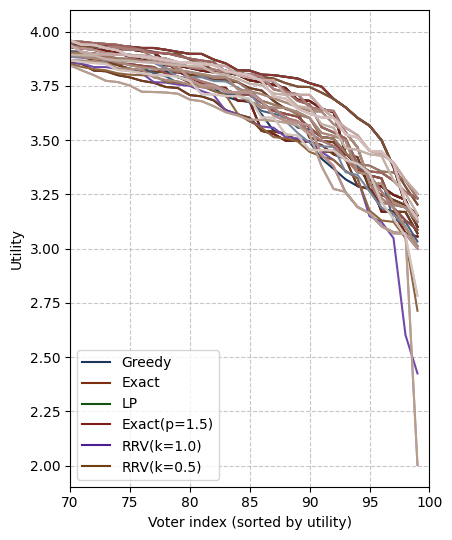

In [105]:

# Plot sorted utility distributions
# Lines with the same algorithm (first level) will have similar colors
fig = plot_sorted_utility_distributions(utilities_for_line_plot, figsize=(4.5, 5.5))
ax = plt.gca()
ax.set_xlim([70, 100])

G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:231: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for group_name, group_data in groups:


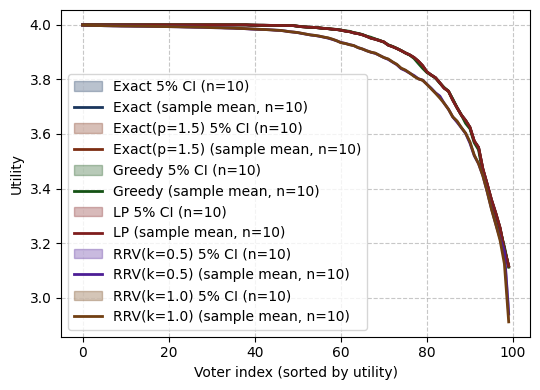

In [119]:
figs = plot_sorted_utility_CIs(utilities_for_line_plot, confidence_level=.05, figsize=(5.5, 4))

In [107]:
# Compute utilities relative to Exact for each run_id
# First, sort each column independently (including "Exact" columns)
# Then, for each run_id, subtract the sorted "Exact" column values from all sorted columns with that run_id
sorted_utilities_relative_to_exact = utilities_swapped_index_levels.copy()

# Sort each column independently
for col in sorted_utilities_relative_to_exact.columns:
    sorted_utilities_relative_to_exact[col] = sorted_utilities_relative_to_exact[col].sort_values(ascending=False).values

# Check if columns are MultiIndex or simple
if isinstance(utilities_swapped_index_levels.columns, pd.MultiIndex):
    # MultiIndex case: columns are (algorithm, run_id)
    for run_id in utilities_swapped_index_levels.columns.get_level_values('run_id').unique():
        # Find the "Exact" column for this run_id
        exact_cols = [
            col for col in utilities_swapped_index_levels.columns
            if col[1] == run_id and col[0] == 'Exact'
        ]
        
        if len(exact_cols) == 0:
            # No Exact column for this run_id, skip
            continue
        elif len(exact_cols) > 1:
            # Multiple Exact columns, use the first one (shouldn't happen normally)
            exact_col = exact_cols[0]
        else:
            exact_col = exact_cols[0]
        
        # Get the sorted Exact values for this run_id
        exact_values = sorted_utilities_relative_to_exact[exact_col]
        
        # Subtract from all columns with this run_id
        for col in utilities_swapped_index_levels.columns:
            if col[1] == run_id:
                sorted_utilities_relative_to_exact[col] = sorted_utilities_relative_to_exact[col] - exact_values
else:
    # Simple columns case: find the "Exact" column
    exact_cols = [
        col for col in utilities_swapped_index_levels.columns
        if col == 'Exact'
    ]
    
    if len(exact_cols) > 0:
        exact_col = exact_cols[0]
        exact_values = sorted_utilities_relative_to_exact[exact_col]
        
        # Subtract from all columns
        for col in utilities_swapped_index_levels.columns:
            sorted_utilities_relative_to_exact[col] = sorted_utilities_relative_to_exact[col] - exact_values

# Filter out all "Exact" columns at the end
if isinstance(sorted_utilities_relative_to_exact.columns, pd.MultiIndex):
    # MultiIndex case: filter out columns where algorithm name starts with "Exact"
    filtered_cols = [
        col for col in sorted_utilities_relative_to_exact.columns
        if not str(col[0]) == 'Exact'
    ]
    sorted_utilities_relative_to_exact = sorted_utilities_relative_to_exact[filtered_cols]
else:
    # Simple columns case: filter out columns that start with "Exact"
    filtered_cols = [
        col for col in sorted_utilities_relative_to_exact.columns
        if not str(col) == 'Exact'
    ]
    sorted_utilities_relative_to_exact = sorted_utilities_relative_to_exact[filtered_cols]

sorted_utilities_relative_to_exact

algorithm,Greedy,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5),Greedy,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5),...,Greedy,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5),Greedy,LP,Exact(p=1.5),RRV(k=1.0),RRV(k=0.5)
run_id,0,0,0,0,0,1,1,1,1,1,...,8,8,8,8,8,9,9,9,9,9
generation1,0.0,0.0,0.0,-0.002173,-0.002173,0.000000,0.0,0.0,-0.001123,-0.001123,...,0.0,0.0,0.0,-0.000869,-0.000869,0.0,0.0,0.0,-0.000957,-0.000957
generation2,0.0,0.0,0.0,-0.002394,-0.002394,0.000000,0.0,0.0,-0.002025,-0.002025,...,0.0,0.0,0.0,-0.001698,-0.001698,0.0,0.0,0.0,-0.001650,-0.001650
generation3,0.0,0.0,0.0,-0.002407,-0.002407,0.000000,0.0,0.0,-0.002144,-0.002144,...,0.0,0.0,0.0,-0.002263,-0.002263,0.0,0.0,0.0,-0.001777,-0.001777
generation4,0.0,0.0,0.0,-0.003044,-0.003044,0.000000,0.0,0.0,-0.002505,-0.002505,...,0.0,0.0,0.0,-0.002305,-0.002305,0.0,0.0,0.0,-0.002058,-0.002058
generation5,0.0,0.0,0.0,-0.003121,-0.003121,0.000000,0.0,0.0,-0.003112,-0.003112,...,0.0,0.0,0.0,-0.002342,-0.002342,0.0,0.0,0.0,-0.002252,-0.002252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
generation96,0.0,0.0,0.0,-0.023808,-0.023808,-0.044375,0.0,0.0,-0.044375,-0.044375,...,0.0,0.0,0.0,-0.015930,-0.015930,0.0,0.0,0.0,-0.102812,-0.102812
generation97,0.0,0.0,0.0,-0.038526,-0.038526,0.014387,0.0,0.0,0.014387,0.014387,...,0.0,0.0,0.0,-0.007149,-0.007149,0.0,0.0,0.0,-0.235263,-0.235263
generation98,0.0,0.0,0.0,-0.022941,-0.022941,0.001419,0.0,0.0,0.001419,0.001419,...,0.0,0.0,0.0,-0.081302,-0.081302,0.0,0.0,0.0,-0.253599,-0.253599


G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:231: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for group_name, group_data in groups:


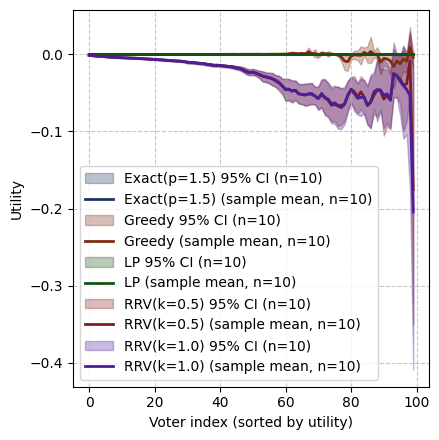

In [118]:
fig1 = plot_sorted_utility_CIs(sorted_utilities_relative_to_exact, figsize=(4.5, 4.5), confidence_level=.95, do_sort=False)
ax1 = plt.gca()
# ax1.set_xlim([50, 100])
# Matplotlib does not support a negative logarithmic scale directly.
# To mimic a "negative log" scale, you can invert the y-axis and plot the log of the negated data.
# However, here we just set the y-axis to be reversed and add a log scale for positive values
# (Note: this makes sense only if you pre-transform your data to -data and plot that).
# ax1.invert_yaxis()
# ax1.set_yscale('log')